# Computing Selection Coefficients for Length Mutations with Discrete Steps

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In this notebook we investigate the dynamics of length evolution. We have to consider that the probability of removing a position from a site depends more strongly on the state of the site than when adding a position, since adapted sites have more specific positions which are beneficial to the interaction with the binding molecule.

First we import necessary packages and set the plotting style. (If default plotting style is wanted, `Jedi.jl` does not need to be imported.)

In [25]:
using Jedi, Plots, Measures, LambertW, CSV, DataFrames, Statistics, LaTeXStrings, Jevo, JLD, Printf

Jedi.default_gr!()

Plots.GRBackend()

First we set the parameters and initiate the fitness landscape.

In [103]:
N = 100
f0 = 50/2N
ϵ = 2
n = 4

# Length scale
l0() = 1/2 * lambertw(2 * ϵ^2 * N * 10 * f0 * (n-1)/n^2 * exp(10))
l0_κ(κ, l) = 1/2 * lambertw(2 * ϵ^2 * N * l * f0 * (n-1)/n^2 * exp(10)/(1 + κ))

# Find length cost to set length in equilibrium (derived from genetic load)
lambda(l_opt) = l0()^2/l_opt^2 * n^2 / (n-1) * 1/ϵ

# Find length cost to set length in equilibrium (derived from genetic load modified by length dynamics)
lambda_new(l_opt) = l0()^3 / l_opt^2 * n^2 / (n-1) * 1/2

l_opt_static(κ) = l0() * sqrt(n^2 / ((n - 1) * ϵ * lambda(10)) * (1+κ))
l_opt_dynamic(κ) = l0()^(3/2) * sqrt(n^2 / ((n - 1) * 2 * lambda_new(10)) * (1+κ))

# Initiate fitness landscape
F = Jevo.fermi_fitness(f0=f0, fl=lambda(10)/(2N*l0()));

Use function to compute predicted mutation selection balance. The derivation can be found in Supplementary methods 3.

In [90]:
function theoretical_msb(κ, l::Array{Int64, 1}=collect(8:40))
    l_0 = [l0_κ(κ, L) for L in l]
    #l_0 = l0()
    k_msb = -l_0  .+ (l .* (3/4))
    return ϵ * k_msb
end

theoretical_msb (generic function with 2 methods)

First let's look at the predicted genetic load at equilibrium for given binding site length, and see if we indeed fix t

Here we can clearly see how the load is minimal for $l=10$ for these parameters. However, this calculation does not consider the asymmetry of length mutations, which come from the fact that when adding a position, the position is random compared to the optimal letter at that position. When removing a position, it is likely to hit an adapated site, whose removal comes with a negative effect to the binding site.

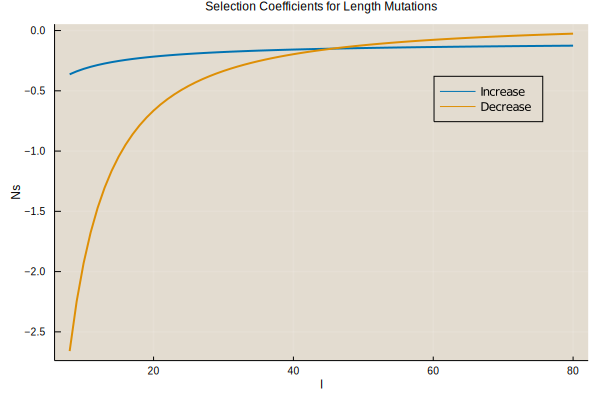

In [91]:
l = collect(8:80)

k = theoretical_msb(0, l)
s_plus_match = Jevo.fitness.(k, l .+ 1, F) .- Jevo.fitness.(k, l, F)
s_plus_mismatch = Jevo.fitness.(k .+ ϵ, l .+ 1, F) .- Jevo.fitness.(k, l, F)


k = theoretical_msb(0, l .+ 1)
s_minus_match = Jevo.fitness.(k, l, F) .- Jevo.fitness.(k, l .+ 1, F)
s_minus_mismatch = Jevo.fitness.(k .- ϵ, l, F) .- Jevo.fitness.(k, l .+ 1, F)


plot(
    8:80, 
    ((1/4 .* s_plus_match) .+ (3/4 .* s_plus_mismatch)) * N, 
    label="Increase",
    ylabel="Ns",
    xlabel="l",
    linewidth=2,
    title="Selection Coefficients for Length Mutations",
)

plot!(
    8:80, 
    ((k/ϵ ./ (l.+1) .* s_minus_mismatch) .+ ((1 .- k/ϵ ./ (l.+1)) .* s_minus_match)) * N, 
    label="Decrease",
    linewidth=2,
)

Here we can clearly see that for these parameters, length decrease mutations are much more deleterious than length increase mutations. Also interesting is that both types of mutations are deleterious. However, this should still lead to a lenght increase, since these mutations are less deleterious. Followed by a length mutation is an adaptation period, since length mutations are assumed to be rare. Thus, we can look at the fitness gain/loss that occurs due to the relaxation to steady state at the current binding site length.

We can try increasing the fitness cost for binding length, which should put length decrease mutations at more of an advantage.

Here we can see that there is a length where the length increase and decrease mutations have an intersection. From the selection coefficients we can compute substitution rates for increase and decrease mutations.

In [92]:
function length_rates(κ::Real, F::Jevo.fitness_functions, l::Array{Int, 1}=collect(8:40))
    k = theoretical_msb(κ, l .+ 1)
    s_plus_match = Jevo.fitness.(k, l .+ 1, F) .- Jevo.fitness.(k, l, F)
    s_plus_mismatch = Jevo.fitness.(k .+ ϵ, l .+ 1, F) .- Jevo.fitness.(k, l, F)


    k = theoretical_msb(κ, l .+ 1)
    s_minus_match = Jevo.fitness.(k, l, F) .- Jevo.fitness.(k, l .+ 1, F)
    s_minus_mismatch = Jevo.fitness.(k .- ϵ, l, F) .- Jevo.fitness.(k, l .+ 1, F)
    
    up = Jevo.kimura_prob.(((1/4 .* s_plus_match) .+ (3/4 .* s_plus_mismatch)), N)
    down = Jevo.kimura_prob.(((k/ϵ ./ (l .+ 1) .* s_minus_mismatch) .+ ((1 .- k/ϵ ./ (l.+1)) .* s_minus_match)), N)
    return up, down
end


length_rates (generic function with 4 methods)

From the rates, we can compute a marginal length distribution, assuming detailed balance, which we can do due to the separation of time scales. Let's first look at the distribution for the initial fitness cost for length.

In [93]:
function p_length(κ::Real, F::Jevo.fitness_functions, l::Array{Int, 1})
    up, down = length_rates(κ, l)
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    return p_l
end

p_length (generic function with 3 methods)

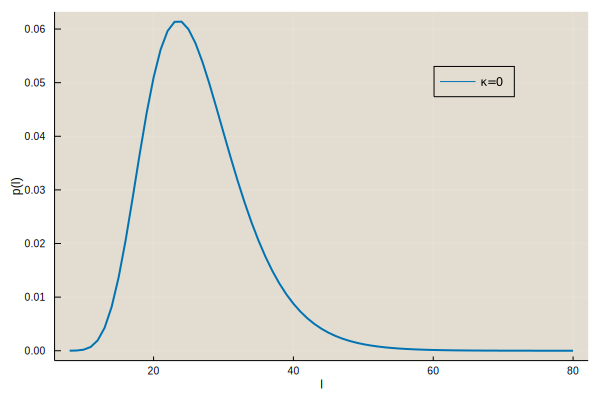

In [94]:
F = Jevo.fermi_fitness(f0=f0, fl=lambda(10)/(2N*l0()))
plot(8:80, p_length(0, F, collect(8:80)), xlabel="l", ylabel="p(l)", linewidth=2, label="κ=0")

We see that the distribution is peaked around values much higher than the predicted length from the genetic load observation, which was around $l=10$ for these values. Let's have a look at how this distribution behaves with increased non-equilibrium.

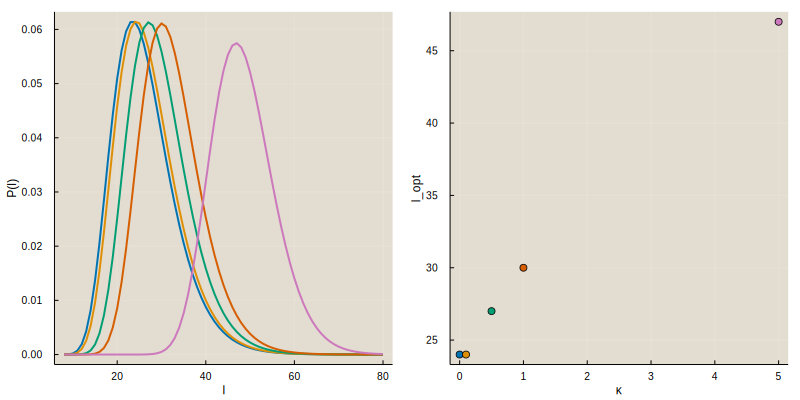

In [95]:
p_left = plot(xlabel="l", ylabel="P(l)")
p_right = plot(xlabel="κ", ylabel="l_opt")

for κ in [0, 0.1, 0.5, 1, 5]
    p_l = p_length(κ, F, collect(8:80))
    scatter!(p_right, [κ], [argmax(p_l) + 7])
    plot!(p_left, 8:80, p_l, linewidth=2, label="κ=$κ")
end

plot(p_left, p_right, size=(800, 400),legend=:none)

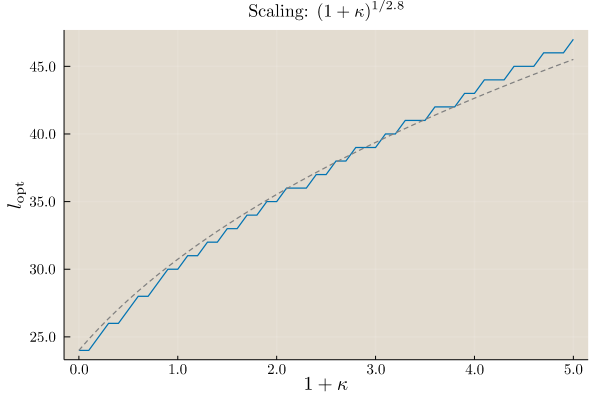

In [96]:
l_opt_arr = []
for κ in 0:0.1:5
    p_l = p_length(κ, F, collect(8:80))
    push!(l_opt_arr, argmax(p_l) + 7)
    #push!(l_opt, sum(collect(8:60) .* p_l))
end
p = plot(
    0.:0.1:5, 
    l_opt_arr, 
    xlabel=L"$1 + \kappa$", 
    ylabel=L"$l_\mathrm{opt}$",
    labelfontsize=13
)
x = 0.:0.1:5 |> collect
plot!(
    p, 
    x, 
    l_opt_arr[1] * (x .+ 1).^(1/2.8), 
    color="gray", 
    linestyle=:dash, 
    title=L"$\textrm{Scaling: }(1+\kappa)^{1/2.8}$", 
    titlefontsize=12,
    xformatter=x->latexstring("$x"),
    yformatter=x->latexstring("$x"),
    tickfontsize=10
)

And now with a higher length cost.

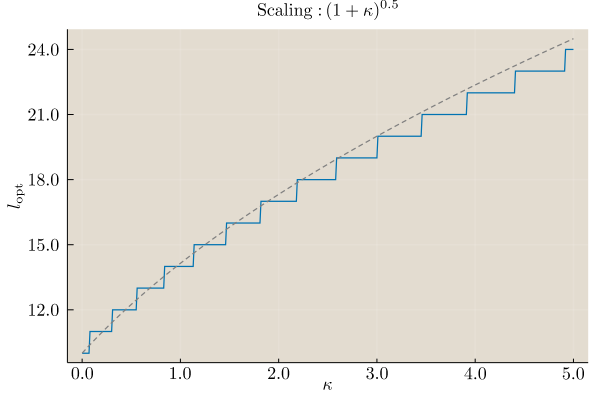

In [97]:
F.fl = lambda_new(10)/(2N*l0())

l_opt_arr2 = []
for κ in 0:0.01:5
    p_l = p_length(κ, F, collect(8:80))
    push!(l_opt_arr2, argmax(p_l) + 7)
end
plot(
    0:0.01:5, 
    l_opt_arr2, 
    xlabel=L"$\kappa$", 
    ylabel=L"$l_\mathrm{opt}$",
    labelfontsize=12,
    tickfontsize=12,
    xformatter=x->latexstring("$x"),
    yformatter=x->latexstring("$x"),
)
plot!(
    0:0.01:5, 
    l_opt_arr2[1] .* collect(1:0.01:6).^0.5, 
    color="gray", 
    linestyle=:dash,
    title=L"$\mathrm{Scaling:}\, (1+\kappa)^{0.5}$",
    titlefontsize=12
)


Let's compare this to the load prediction that we made in another notebook (The array below is simply copied from there).

This looks great.

0.25

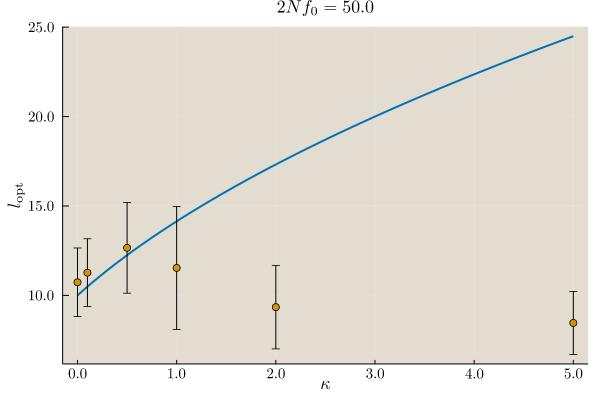

In [127]:
df = CSV.read("../outputs/2020_12_10_supp5_script_0.csv", DataFrame)
cdf = combine(groupby(df, "rho"), [:l] =>((x) -> (l_mean=mean(x), l_std=std(x))) =>
               AsTable)
parameters1 = Jevo.parse_metadata("../outputs/2020_12_10_supp5_script_METADATA_0.txt")
print(parameters1["f0"])

f0 = parse(Float64, parameters1["f0"])
F.f0 = f0
F.fl = lambda_new(10)/(2N*l0())

l_opt_arr2 = []
for κ in 0:0.01:5
    p_l = p_length(κ, F, collect(8:80))
    push!(l_opt_arr2, argmax(p_l) + 7)
end
p1 = plot(
    0:0.01:5, 
    [l_opt_dynamic(κ) for κ in (collect(0:0.01:5))],
    xlabel=L"$\kappa$", 
    ylabel=L"$l_\mathrm{opt}$",
    tickfontsize=10,
    xformatter=x->latexstring("$x"),
    yformatter=x->latexstring("$x"),
    linewidth=2,
    title=latexstring("2Nf_0=", "$(f0*2N)"),
    titlefontsize=12,
    labelfontsize=12,
)


scatter!(
    p1,
    cdf.rho, 
    cdf.l_mean, 
    yerror=cdf.l_std, 
    color=palette(:seaborn_colorblind)[2], 
    markerstrokecolor="black",#palette(:seaborn_colorblind)[2],
    linewidth=1
)

1.5

1.5

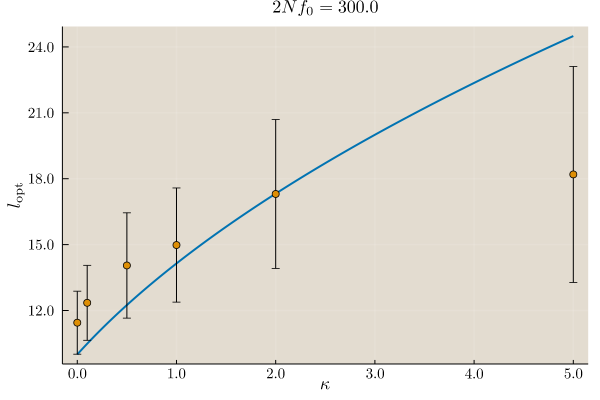

In [128]:
df = CSV.read("../outputs/2020_12_10_supp5_script.csv", DataFrame)
cdf = combine(groupby(df, "rho"), [:l] =>((x) -> (l_mean=mean(x), l_std=std(x))) =>
               AsTable)
parameters2 = Jevo.parse_metadata("../outputs/2020_12_10_supp5_script_METADATA.txt")
print(parameters2["f0"])

f0 = parse(Float64, parameters2["f0"])
F.f0 = f0
F.fl = lambda_new(10)/(2N*l0())

l_opt_arr2 = []
for κ in 0:0.01:5
    p_l = p_length(κ, F, collect(8:80))
    push!(l_opt_arr2, argmax(p_l) + 7)
end
p2 = plot(
    0:0.01:5, 
    [l_opt_dynamic(κ) for κ in (collect(0:0.01:5))],
    xlabel=L"$\kappa$", 
    ylabel=L"$l_\mathrm{opt}$",
    tickfontsize=10,
    xformatter=x->latexstring("$x"),
    yformatter=x->latexstring("$x"),
    linewidth=2,
    title=latexstring("2Nf_0=", "$(f0*2N)"),
    titlefontsize=12,
    labelfontsize=12,
)


scatter!(
    p2,
    cdf.rho, 
    cdf.l_mean, 
    yerror=cdf.l_std, 
    color=palette(:seaborn_colorblind)[2], 
    markerstrokecolor="black",#palette(:seaborn_colorblind)[2],
    linewidth=1,
)

Now we can reconstruct the join probabiliy $Q(\Gamma,l)$ by multiplying the marginal length distribution to the conditional distrbution for binding energies at given lengths.

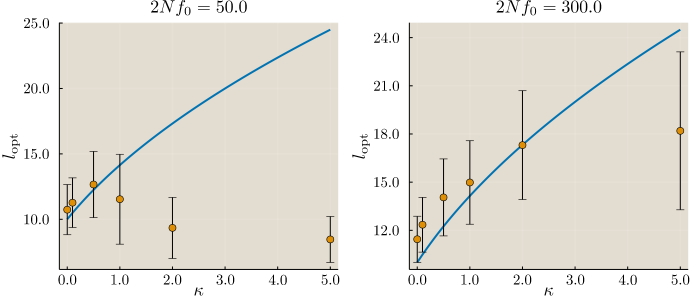

In [129]:
p3 = plot(p1, p2, size=(700, 300))

In [130]:
savefig(p3, "../figures/optim_l_dynamic_with_sim.pdf")

In [108]:
function fixed_l_Q(rho, F, l_arr::Array{Int, 1}=collect(8:40))
    Q_k = zeros(Float64, length(l_arr), 101)
    for (j, l_0) in enumerate(l_arr)
        F.l = l_0
        for (i, g) in enumerate(0:0.01:1)
            Q_k[j, i] = exp(-1/2*(l_0 * (g-3/4))^2/(3*l_0/16)) * exp(2N/(1+rho)*fitness(2l_0*g, F))
        end
    end
    return Q_k
end

fixed_l_Q (generic function with 2 methods)

In [32]:
function twoDQ(rho, F, l_arr::Array{Int, 1}=collect(8:40))
    Q = fixed_l_Q(rho, F, l_arr)
    
    up, down = length_rates(rho, l_arr)
    
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    Q_l = Q .* p_l
    p1 = heatmap(
        l_arr, 
        0:0.01:1, 
        Q_l', 
        color=:viridis, 
        title=L"$\rho$="*"$rho", 
        colorbar=false, 
        #top_margin=6mm, 
        xlabel="l", 
        ylabel="γ", 
        #bottom_margin=10mm,
        #left_margin=5mm,
        #right_margin=5mm,
        titlefontsize=8
    )
    return p1
end

default_pyplot!()
plot([twoDQ(rho, F, collect(8:30)) for rho in [0, 0.1, 0.5, 1, 1.5, 2]]..., layout=(2,3), size=(700, 400), link=:all)
#twoDQ(0, F)

LoadError: UndefVarError: default_pyplot! not defined

In [33]:
savefig("../figures/moving_dist_discrete.pdf")

In [34]:
function twoDQ(rho, F, l_arr::Array{Int, 1}=collect(8:40))
    Q = fixed_l_Q(rho, F, l_arr)
    
    up, down = length_rates(rho, l_arr)
    
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    Q_l = Q .* p_l
    p1 = contourf(
        l_arr, 
        0:0.01:1, 
        Q_l', 
        color=:viridis, 
        title=L"$\rho$="*"$rho", 
        colorbar=false, 
        #top_margin=6mm, 
        xlabel="l", 
        ylabel="γ", 
        #bottom_margin=10mm,
        #left_margin=5mm,
        #right_margin=5mm,
        titlefontsize=8,
        levels=8
    )
    return p1
end

default_pyplot!()
plot([twoDQ(rho, F, collect(8:30)) for rho in [0, 0.1, 0.5, 1, 1.5, 2]]..., layout=(2,3), size=(700, 400), link=:all)

LoadError: UndefVarError: default_pyplot! not defined

In [35]:
savefig("../figures/moving_dist_contour.pdf")

## Data

In [36]:
df = CSV.read("../outputs/2020_09_03_script4_results.csv")

LoadError: ArgumentError: provide a valid sink argument, like `using DataFrames; CSV.read(source, DataFrame)`

In [37]:
df_ends = df[1000:1000:end, :]


,gamma,l,rho
,Float64,Float64,Float64


In [38]:
gdf = groupby(df_ends, :rho)
cdf_means = combine([:l, :Gamma] => (x, y) -> (mean_l=mean(x), mean_gamma=mean(y)), gdf)

LoadError: ArgumentError: First argument must be a transformation if the second argument is a GroupedDataFrame. You can pass a `Pair` as the second argument of the transformation. If you want the return value to be processed as having multiple columns add `=> AsTable` suffix to the pair.

In [39]:
plot(
    plot(
        cdf_means.rho, 
        cdf_means.mean_l, 
        xlabel="ρ", 
        ylabel="mean length"
        ), 
    plot(
        cdf_means.rho, 
        cdf_means.mean_gamma./2,
        xlabel="ρ",
        ylabel="mean gamma",
    ),
    size=(350, 150),
    margin=4mm
)

LoadError: UndefVarError: cdf_means not defined

In [40]:
function show_hists(df, rho)
    gdf_l = groupby(df, [:rho, :l])
    cdf_hists_l = combine(gdf_l, nrow)
    
    gdf_gamma = groupby(df, [:rho, :Gamma, :l])
    cdf_hists_gamma = combine(gdf_gamma, nrow)
    
    return plot(
        scatter(cdf_hists_l[cdf_hists_l.rho .== rho, :l], cdf_hists_l[cdf_hists_l.rho .== rho, :nrow]),
        scatter(
            cdf_hists_gamma[cdf_hists_gamma.rho .== rho, :l], 
            cdf_hists_gamma[cdf_hists_gamma.rho .== rho, :Gamma] ./2cdf_hists_gamma[cdf_hists_gamma.rho .== rho, :l]),
        size=(350, 150)
        )
end

show_hists(df_ends, 0)


LoadError: ArgumentError: column name :Gamma not found in the data frame; existing most similar names are: :gamma

In [41]:
rho = 0
tdf = df[df.rho.==rho, :]
tdf.Gamma = tdf.Gamma./2tdf.l

default_plotlyjs!()
histogram2d(tdf.l, tdf.Gamma, nbins=15)

LoadError: ArgumentError: column name :Gamma not found in the data frame; existing most similar names are: :gamma

In [42]:
tdf.Gamma

LoadError: ArgumentError: column name :Gamma not found in the data frame; existing most similar names are: :gamma